
# **0. Mask augmentation**

*   mount google drive
*   MaskTheFace github (https://github.com/aqeelanwar/MaskTheFace.git)
*   include mask augmented face image samples in report



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# drive mount 후 colab의 현재 경로 /content
# ! git clone https://github.com/aqeelanwar/MaskTheFace.git

In [3]:
! pip install wandb

# MaskTheFace Package 설치 (MaskTheFace 관련 코드는 주석처리 해놓음)
# ! pip install dlib
# ! pip install face-recognition
# ! pip install face-recognition-models
# ! pip install dotmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.4 MB/s eta 0:00:00


In [ ]:
# # import packages
# from pathlib import Path
# import os, shutil

# # DATA_URL = "mask_data" # 구글 드라이브에서의 폴더 이름
# ZIP_FILENAME = "data_original.zip" # 폴더 안에 있는 data.zip 원본 파일 이름
# UNZIP_DESTINATION = "dataset" # Colab VM에 저장될 폴더 이름
# NUM_WORKERS = os.cpu_count()

# DRIVE_URL = Path('/content/drive/MyDrive')
# ORIGINAL_DATA_URL = DRIVE_URL / ZIP_FILENAME

# BASE_URL = Path("/content")

# if not (BASE_URL / UNZIP_DESTINATION).exists():
#   (BASE_URL / UNZIP_DESTINATION).mkdir()

# if not (BASE_URL / ZIP_FILENAME).exists() and ORIGINAL_DATA_URL.exists():
#   shutil.copy2(ORIGINAL_DATA_URL, BASE_URL)

# if (BASE_URL / ZIP_FILENAME).exists():
#   os.system(f"unzip {ZIP_FILENAME} -d {UNZIP_DESTINATION}")
#   (BASE_URL / ZIP_FILENAME).unlink()

# BASE_URL = BASE_URL / UNZIP_DESTINATION

In [ ]:
# cd 'MaskTheFace'

In [ ]:
# ! python mask_the_face.py --path "/content/dataset/train/not_wearing_mask" --mask_type "random"

In [ ]:
# ! python mask_the_face.py --path "/content/dataset/val/not_wearing_mask" --mask_type "random"

In [ ]:
# directories = {
#     "train": {
#         "masked": "/content/dataset/train/not_wearing_mask_masked",
#         "wearing": "/content/dataset/train/wearing_mask"
#     },
#     "val": {
#         "masked": "/content/dataset/val/not_wearing_mask_masked",
#         "wearing": "/content/dataset/val/wearing_mask"
#     }
# }

# for key, paths in directories.items():
#     SOURCE = paths["masked"]
#     DESTINATION = paths["wearing"]

#     if os.path.exists(SOURCE):
#         shutil.rmtree(DESTINATION)

#     os.rename(SOURCE, DESTINATION)

# **1. Prepare Data for Training**

*   data_loader using *torchvision.datasets.ImageFolder* for Custom dataset
*   **image augmentation** in *transforms*
*   include augmented face image samples in report



In [4]:
# import packages
from pathlib import Path
import os, shutil

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.transforms import v2

from tqdm import tqdm
from sklearn import metrics

# DATA_URL = "mask_data" # 구글 드라이브에서의 폴더 이름
ZIP_FILENAME = "data.zip" # 폴더 안에 있는 zip 파일 이름
UNZIP_DESTINATION = "dataset" # Colab VM에 저장될 폴더 이름
NUM_WORKERS = os.cpu_count()

DRIVE_URL = Path('/content/drive/MyDrive')
ORIGINAL_DATA_URL = DRIVE_URL / ZIP_FILENAME

BASE_URL = Path("/content")

if not (BASE_URL / UNZIP_DESTINATION).exists():
  (BASE_URL / UNZIP_DESTINATION).mkdir()

if not (BASE_URL / ZIP_FILENAME).exists() and ORIGINAL_DATA_URL.exists():
  shutil.copy2(ORIGINAL_DATA_URL, BASE_URL)

if (BASE_URL / ZIP_FILENAME).exists():
  os.system(f"unzip {ZIP_FILENAME} -d {UNZIP_DESTINATION}")
  (BASE_URL / ZIP_FILENAME).unlink()

drive.flush_and_unmount()

BASE_URL = BASE_URL / UNZIP_DESTINATION

In [5]:
# transforms for image augmentation
train_transform = transforms.v2.Compose([
    v2.CenterCrop(112),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(degrees=(0, 180)),
    # v2.ColorJitter(),
    # v2.Grayscale(num_output_channels=3),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    v2.RandomPerspective(distortion_scale=0.6, p=1.0),
    # scale=True의 의미: https://pytorch.org/vision/main/transforms.html#dtype-and-expected-value-range
    # v2를 사용한 이유: https://pytorch.org/vision/main/transforms.html#v1-or-v2-which-one-should-i-use
    # v2를 사용하면 ToTensor 대신 ToImage와 ToDtype의 조합 사용해야함.
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True), # scale=True -> [0, 1] 사이로 값 조정
])

val_transform = transforms.v2.Compose([
    v2.CenterCrop(112),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(degrees=(0, 180)),
    # v2.ColorJitter(),
    # v2.Grayscale(num_output_channels=3),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    v2.RandomPerspective(distortion_scale=0.6, p=1.0),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
])

test_transform = transforms.v2.Compose([
    v2.Resize(128),
    v2.CenterCrop(112),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(degrees=(0, 180)),
    # v2.ColorJitter(),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    v2.RandomPerspective(distortion_scale=0.6, p=1.0),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
])

In [6]:
from torchvision.datasets import ImageFolder

train_path = BASE_URL / 'train'
val_path = BASE_URL / 'val'
test_path = BASE_URL / 'test'

# write ImageFolder code below
train_dataset = ImageFolder(train_path, transform=train_transform)
val_dataset = ImageFolder(val_path, transform=val_transform)
test_dataset = ImageFolder(test_path, transform=test_transform)

# check the label
# train_data.class_to_idx -> {'not_wearing_mask': 0, 'wearing_mask': 1}
# val_data.class_to_idx -> {'not_wearing_mask': 0, 'wearing_mask': 1}
print(f"{train_path} : {train_dataset.class_to_idx}")
print(f"{val_path}: {val_dataset.class_to_idx}")

/content/dataset/train : {'not_wearing_mask': 0, 'wearing_mask': 1}
/content/dataset/val: {'not_wearing_mask': 0, 'wearing_mask': 1}


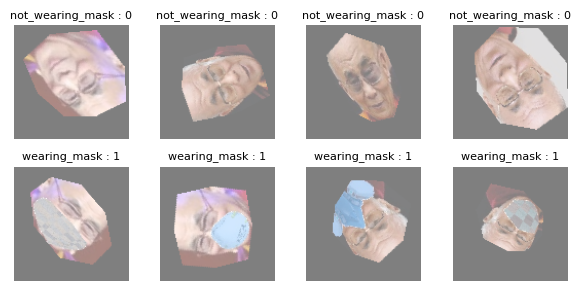

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, ax=None, title=None, fontsize=8):
    if ax is None:
        ax = plt.gca()
    img = img / 2 + 0.5  # unnormalize if normalization was applied
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        ax.set_title(title, fontsize=fontsize)
    ax.axis('off')

# 이미지와 라벨 출력
def show_images(dataset, predicted_labels=None, num_images_per_class=4):
    class_indices = {class_name: [] for class_name in dataset.class_to_idx.keys()}

    for idx, (img, label) in enumerate(dataset):
        class_name = list(dataset.class_to_idx.keys())[label]
        if len(class_indices[class_name]) < num_images_per_class:
            class_indices[class_name].append(idx)
        if all(len(indices) == num_images_per_class for indices in class_indices.values()):
            break

    fig, axes = plt.subplots(2, 4, figsize=(6, 3))
    axes = axes.flatten()
    for i, class_name in enumerate(class_indices.keys()):
        for j, idx in enumerate(class_indices[class_name]):
            img, label = dataset[idx]
            title = f"{class_name} : {label}"

            if predicted_labels is not None:
              predicted_label = predicted_labels[idx]
              title += f"\nprediction : {predicted_label}"
            ax = axes[i * num_images_per_class + j]
            imshow(img, ax=ax, title=title)
    plt.tight_layout()
    plt.show()

# 이미지 출력
show_images(train_dataset)

# **2. Prepare Model**

*   Pytorch ResNet - *ref*. https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
*   use **ResNet50** from torchvision.model_zoo
*   explore more models in https://pytorch.org/vision/stable/models.html
*   **change the dimension of the classifier**

In [8]:
# assign device cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
import torchvision.models as models

def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
  elif isinstance(m, nn.BatchNorm2d):
    nn.init.constant_(m.weight.data, 1)
    nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight.data)
    nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Sequential):
    for sm in list(m):
      initialize_weights(sm)
  elif isinstance(m, models.resnet.Bottleneck):
    for sm in m.children():
      initialize_weights(sm)

def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class ResNet_dp(models.ResNet):
    def __init__(self, block, layers, use_dropout=False, dropout_prob=0.5, **kwargs):
        self.use_dropout = use_dropout
        self.dropout_prob = dropout_prob
        super(ResNet_dp, self).__init__(block, layers, **kwargs)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        if self.use_dropout:
            for layer in layers:
                if hasattr(layer, 'relu'):
                    layer.relu = nn.Sequential(
                        layer.relu,
                        nn.Dropout(self.dropout_prob)
                    )

        return nn.Sequential(*layers)

def init_resnet50(init_weights=False, use_dropout=False, dropout_prob=0.5):
    model = ResNet_dp(models.resnet.Bottleneck, [3, 4, 6, 3], use_dropout=use_dropout, dropout_prob=dropout_prob)
    model.fc = nn.Linear(model.fc.in_features, 1)  # Change the # of classes

    if init_weights:
        model.apply(initialize_weights)

    return model


In [10]:
# load model and change the # of classes
# Example usage
model = init_resnet50(init_weights=False, use_dropout=True, dropout_prob=0.5)
print(model)

ResNet_dp(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sequential(
        (0): ReLU(inplace=True)
        (1): Dropout(p=0.5, inplace=False)
      )
      (downsa

# **3. Training**


*   write **training code** including belows:
   - hyper parameters such as batch size, learning rate, epoch
   - criterion(loss function such as BCELoss), optimizer(eg. Adam, SGD, etc.)  and scheduler
   - save model weight

*   **print training/validation loss and accuracy** per epoch or iteration
*   inlcude visualizer, **tensorboard**, to show training/validation accuracy and loss


In [11]:
import wandb
import sklearn
from sklearn import metrics
import datetime
import os
import torch.optim as optim
from tqdm import tqdm

WANDB_KEY = "8aa54cefa31fe5992ce2d2969f979237aae9f81a"
NUM_WORKERS = os.cpu_count()

wandb.login(key=WANDB_KEY)

def init_wandb(project_name = "ICPBL_REPORT", name="test", config = None):
  if config is None:
    config = {
      "architecture": "ResNet50",
      "learning_rate": 0.01,
      "batch_size": 64,
      "epochs": 50,
      "weight_decay": 0,
      "momentum": 0.93,
      "init_weights": False,
      "optimizer": 'SGD',
      "lr_scheduler": "CosineAnnealing",
    }

  logger = wandb.init(
    # set the wandb project where this run will be logged
    project=project_name,
    name = name,
    # track hyperparameters and run metadata
    config=config
  )

  return logger

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# utils
# import matplotlib.pyplot as plt

def get_labels_from_probs(y_hat):
  return torch.where(F.sigmoid(y_hat.reshape(-1)) > 0.5, 1, 0)

def get_acc(y_hat, labels):
  if torch.is_floating_point(y_hat):
    y_hat = get_labels_from_probs(y_hat)

  return y_hat.eq(labels).sum().item()

def get_roc_curve_data(labels, y_hat):
  y_hat = y_hat.reshape(-1)
  fprs, tprs, _ = metrics.roc_curve(labels, y_hat)
  roc_auc = metrics.roc_auc_score(labels, y_hat)

  return fprs, tprs, roc_auc

def plot_roc_curve(fprs, tprs, roc_auc):
  # sklearn 으로 ROC Curve 그리기
  # ROC Curve를 plot 곡선으로 그림.
  plt.plot(fprs , tprs, label=f'ROC (AUC: {roc_auc:.4f})')
  # 가운데 대각선 직선을 그림.
  plt.plot([0, 1], [0, 1], 'k:', label='Random')
  plt.title('ROC curve')
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(loc='best')
  plt.savefig('ROC.png',dpi=300);
  return

In [26]:
def val_model(model, criterion, dataloader, use_sklearn = False, plot_mask=False):
  # write validation code
  if model.training:
    model.eval()

  accuracy = 0.0
  loss = 0.0

  global_y_hat = torch.Tensor()
  global_y_hat.requires_grad = False
  global_labels = torch.Tensor()
  global_labels.requires_grad = False

  with torch.no_grad():
    for images, labels in tqdm(dataloader, total=len(dataloader)):
      images = images.to(device)
      labels = labels.to(device)

      y_hat = model(images)
      y_hat = y_hat.reshape(-1)

      _l = criterion(y_hat, labels.type(dtype=torch.float32))
      loss += _l.item()

      accuracy += get_acc(y_hat, labels)

      global_y_hat = torch.cat([global_y_hat, y_hat.cpu()], dim=-1)
      global_labels = torch.cat([global_labels, labels.cpu()], dim=-1)

  loss = float("{:.4f}".format(loss / len(dataloader)))
  accuracy = float("{:.4f}".format(accuracy / len(dataloader.dataset)))

  if plot_mask is True:
    predicted_labels = get_labels_from_probs(global_y_hat)
    show_images(dataloader.dataset, predicted_labels)

  fprs, tprs, auc = get_roc_curve_data(global_labels, global_y_hat)

  if use_sklearn:
    plot_roc_curve(fprs, tprs, auc)

  global_y_hat = torch.stack([torch.zeros_like(global_y_hat), global_y_hat], dim=1)
  roc = wandb.plot.roc_curve(global_labels, global_y_hat, labels=["not_wearing_mask", "wearing_mask"])

  return accuracy, loss, auc, roc

In [19]:
def train_model(model, optim, criterion, dataloader, lr_scheduler=None, scheduler_type=None, save_model=True):
  if not model.training:
      model.train()

  accuracy = 0.0
  loss = 0.0

  global_y_hat = torch.Tensor()
  global_labels = torch.Tensor()

  for images, labels in tqdm(dataloader, total=len(dataloader)):
    images = images.to(device)
    labels = labels.to(device)

    y_hat = model(images)
    y_hat = y_hat.reshape(-1)

    _l = criterion(y_hat, labels.type(dtype=torch.float32))

    optim.zero_grad()
    _l.backward()
    optim.step()

    if lr_scheduler is not None and scheduler_type == 'CyclicLR':
      lr_scheduler.step()


    loss += _l
    accuracy += get_acc(y_hat, labels)

    global_y_hat = torch.cat([global_y_hat, y_hat.cpu()], dim=-1)
    global_labels = torch.cat([global_labels, labels.cpu()], dim=-1)

  loss = float("{:.4f}".format(loss / len(dataloader)))
  accuracy = float("{:.4f}".format(accuracy / len(dataloader.dataset)))

  global_y_hat = get_labels_from_probs(global_y_hat)
  f1_score = metrics.f1_score(global_y_hat, global_labels)
  f1_score = float("{:.4f}".format(f1_score))

  if lr_scheduler is not None and scheduler_type in ['StepLR', 'CosineAnnealingLR']:
    lr_scheduler.step()

  return accuracy, loss, f1_score

In [20]:
# hyper parameters
config = {
    "architecture": "ResNet50",
    "learning_rate": 0.01,
    "batch_size": 64,
    "epochs": 50,
    "weight_decay": 0,
    "momentum": 0.93,
    "init_weights": False,
    "optimizer": 'SGD',
    "scheduler_type": '',
}

In [21]:
# optimizer, loss, scheduler
model = init_resnet50(init_weights=config["init_weights"])
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
if config["optimizer"] == 'SGD':
  optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"], momentum=config["momentum"])
elif config["optimizer"] == 'Adam':
  optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
else:
  pass

criterion = nn.BCEWithLogitsLoss()
criterion.to(device)

# lr_scheduler
lr_scheduler = None
if config["scheduler_type"] == 'StepLR':
  lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma=0.8)
elif config["scheduler_type"] == 'CyclicLR':
  lr_scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.005, max_lr=0.015, step_size_up=5, step_size_down=5, mode='triangular')
elif config["scheduler_type"] == 'CosineAnnealingLR':
  lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min = 0.001)
else:
  pass

print(lr_scheduler)

None


In [22]:
# data_loader
train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)
test_dataloader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=NUM_WORKERS, pin_memory=False)

In [23]:
# training and validation code can be writed in one function. It's your taste!
from copy import deepcopy
import json

logger = init_wandb(project_name="ResNet50", config=config)

best_f1_score = 0.0
best_f1_model = None
best_model_metadata = None

for epoch in range(config['epochs']):
  train_acc, train_loss, f1_score = train_model(model, optim=optimizer, criterion=criterion, dataloader=train_dataloader, lr_scheduler=lr_scheduler, scheduler_type=config["scheduler_type"])
  val_acc, val_loss, auc, roc = val_model(model, criterion=criterion, dataloader=val_dataloader)

  logger.log({"train_acc": train_acc}, step=epoch)
  logger.log({"train_loss": train_loss}, step=epoch)
  logger.log({"val_acc": val_acc}, step=epoch)
  logger.log({"val_loss": val_loss}, step=epoch)

  if epoch % 10 == 0:
    logger.log({"roc": roc, "auc": auc})

  if f1_score > best_f1_score:
    best_f1_score = f1_score
    best_f1_model = deepcopy(model.state_dict())
    best_model_metadata = {
        "epoch": epoch
    }

  print("")
  print(f"{'Epoch':<20}:  {epoch+1}")
  print(f"{'Train Accuracy':<20}: {train_acc}")
  print(f"{'Train Loss':<20}: {train_loss}")
  print(f"{'Val Accuracy':<20}: {val_acc}")
  print(f"{'Val Loss':<20}: {val_loss}")
  print("")

wandb.finish()

save_model_path = Path("./best_model.pt")

torch.save(best_f1_model, save_model_path)
with open(Path("./best_model_metadata.json"), 'w', encoding="utf-8") as f:
  json.dump(best_model_metadata, f, ensure_ascii=False, indent=4)

wandb: Currently logged in as: ordidxzero (zettelkasten). Use `wandb login --relogin` to force relogin


  0%|          | 0/268 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 90/90 [00:42<00:00,  2.10it/s]



Epoch               :  1
Train Accuracy      : 0.7562
Train Loss          : 0.4952
Val Accuracy        : 0.8012
Val Loss            : 0.4724



auc,▁
train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
auc,0.89359
train_acc,0.7562
train_loss,0.4952
val_acc,0.8012
val_loss,0.4724


100%|██████████| 90/90 [00:12<00:00,  7.45it/s]


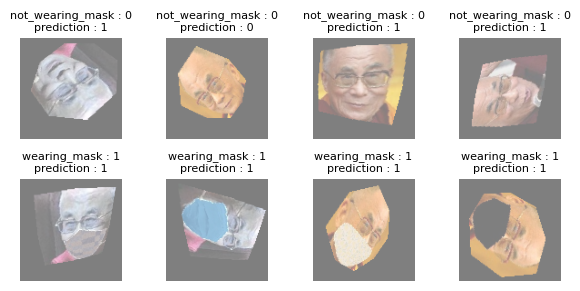

In [29]:
val_acc, val_loss, auc, roc = val_model(model, criterion=criterion, dataloader=val_dataloader, plot_mask=True)

In [ ]:
# ROC curve, AUC (Hint: use sklearn or wandb function, using sklearn to extract fpr, tpr will be bonus score)
model = init_resnet50()
model.load_state_dict(torch.load(save_model_path))
model.to(device)
test_acc, test_loss, roc_auc, roc = val_model(model, criterion=criterion, dataloader=test_dataloader, use_sklearn=True, plot_mask=True)

In [ ]:
print(test_acc)
# print(fpr)
# print(tpr)

# 25